In [2]:
library(data.table)
library(rpart)
library(partykit)
library(ggplot2)
library(Metrics)
library(caret)
library(TSdist)
library(dtw)
library(TunePareto)
options(repr.plot.width=10, repr.plot.height=4)

## Introduction

Aim of this assignment is constructing classification models the different time series data sets. 5 different time series data sets are exctracted from the web site timeseriesclassification.com. First, time series are imported and prepared for the model. In the pre-process, in addition to raw observations, time series are represented in 3 different ways: differenced series, piecewise adaptive representation with tree algorithm with the tree parameter "maxdepth" values of 5 and 10. Then, series are manipulated to calculate distance matrices. To calculate distances, 4 different distance measures are used: Euclidean distance, Dynamic Time Warping with Sakoe-Chiba constraint (DTW), Longest Common Subsequence (LCSS) and Edit Distance on Real Sequences (EDR). Parameters of the distance measure algorithms are taken as default. After the construction of all different distance matrices for all different representations, time series are classified with the k-Nearest Neighbors (k-NN) algorithm. 3 different k-values- 1,3 and 5- are used as model parameters and applied to all distance matrices. To find the best algorithm, 10 fold cross validation with 5 repetitions used to test the performances. Accucarcy is used as the performance measure and best models are found according to mean and standard deviation of the accuracy measures.

## Choosen Time Series Data Sets

### 1) ECG 

ECG data consists of 100 different time series with 96 observations each. Every time series traces the electrical activity recorded during one heartbeat and classified as whether its a normal heartbeat or the patient has Myocardial Infarction.

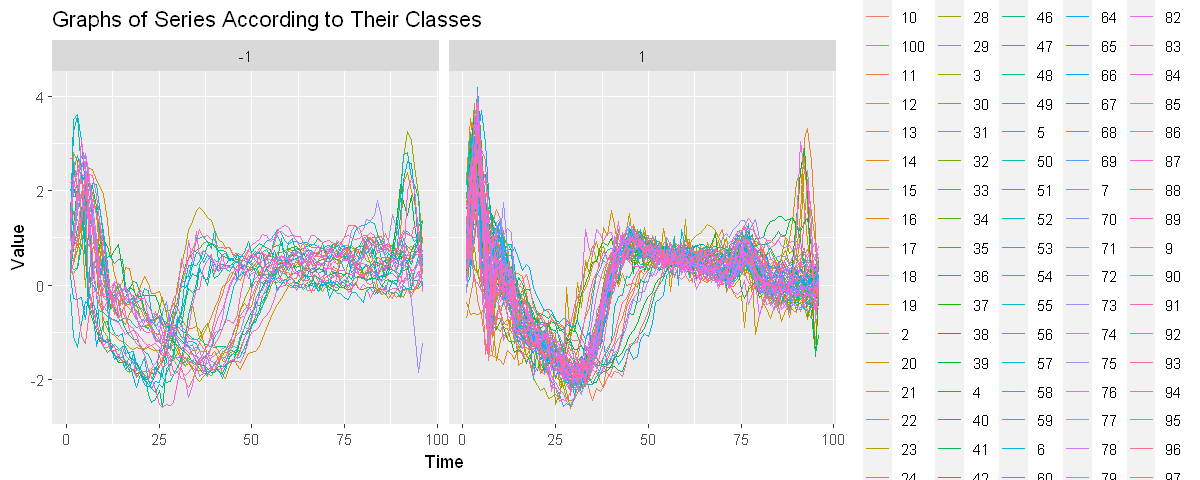

In [37]:
ggplot(series_long[["ecg"]], aes(time,value)) + geom_line(aes(color=as.character(id))) +
     facet_wrap(~class) +
     labs(title= "Graphs of Series According to Their Classes", x= "Time", y="Value")

###  2) Italy's Power Demand

The data was derived from twelve monthly electrical power demand time series from Italy and it consist of 67 time series each with 24 observations. Every observation is an hour of a day and the task is classification of the day according to the demand series. There is two classes which are indicates whether the day belongs to the months from October to March or April to September.

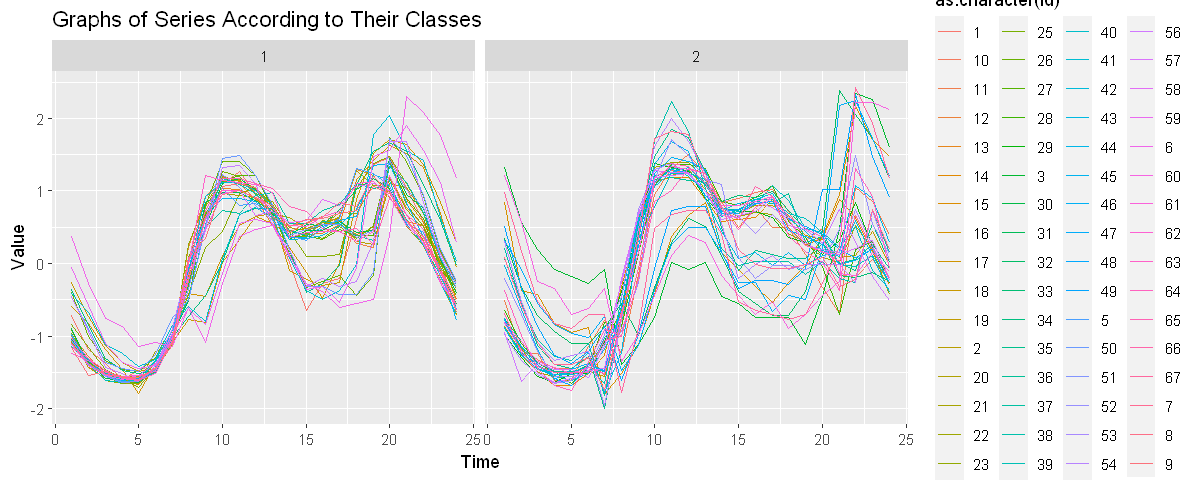

In [39]:
ggplot(series_long[["italy"]], aes(time,value)) + geom_line(aes(color=as.character(id))) +
     facet_wrap(~class) +
     labs(title= "Graphs of Series According to Their Classes", x= "Time", y="Value")

### 3) Smooth Subspaces

Each time series contain a continuous subspace spanning over 5 continuous time stamps. The data was originally intended for testing whether a clustering algorithm is able to extract smooth subspaces for clustering time series data. There are 3 classes corresponding to which cluster the time series belong to.

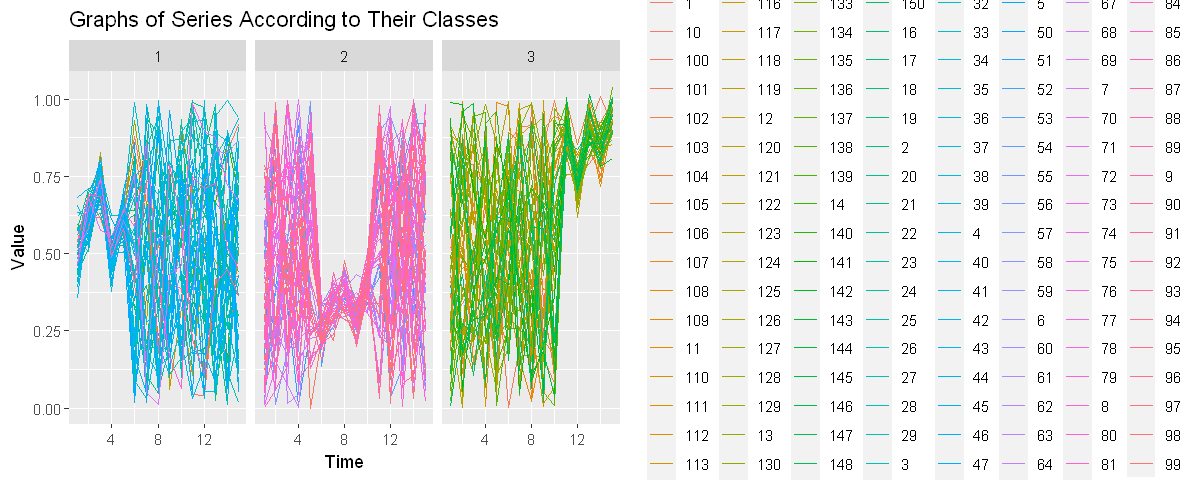

In [40]:
ggplot(series_long[["subspace"]], aes(time,value)) + geom_line(aes(color=as.character(id))) +
     facet_wrap(~class) +
     labs(title= "Graphs of Series According to Their Classes", x= "Time", y="Value")

### 4) Power Cons

The PowerCons dataset contains the individual household electric power consumption in one year distributed in two season classes: warm (class 1) and cold (class 2), depending on whether the power consumption is recorded during the warm seasons (from April to September) or the cold seasons (from October to March). The data consits of 180 time series each with 144 observations. The samples taken in every 10 minutes on a day.

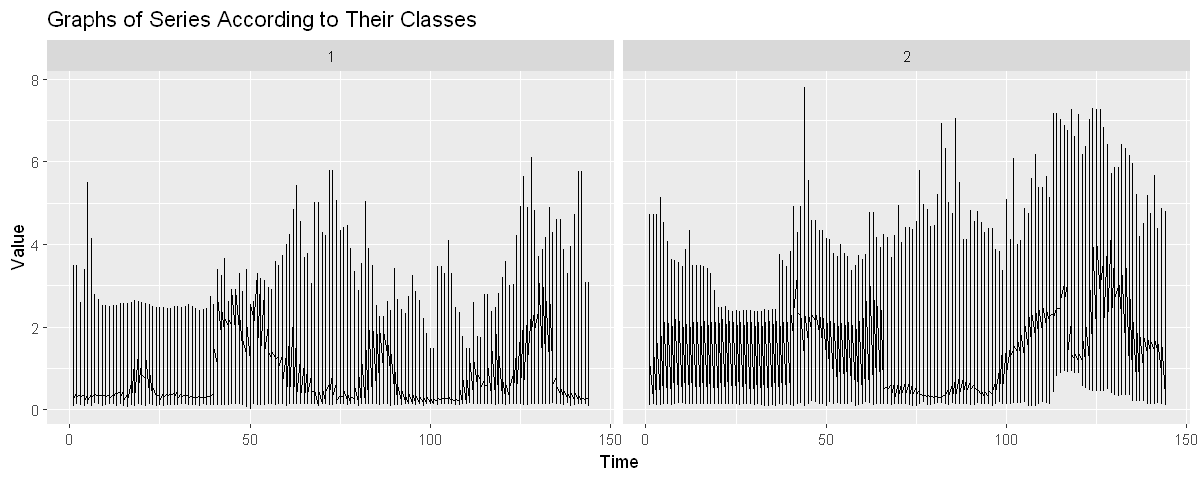

In [42]:
ggplot(series_long[["power"]], aes(time,value)) + geom_line() +
     facet_wrap(~class) +
     labs(title= "Graphs of Series According to Their Classes", x= "Time", y="Value")

### 5) Planes Data Set

Data consists of 105 time series with 144 observetion. Every time series represents the outline of a plane. The task is classification of the plane type which belongs to one of the 7 classes: mirage, eurofighter, F-14 wings closed, F-14 wings opened, harrier, F-22 and F-15

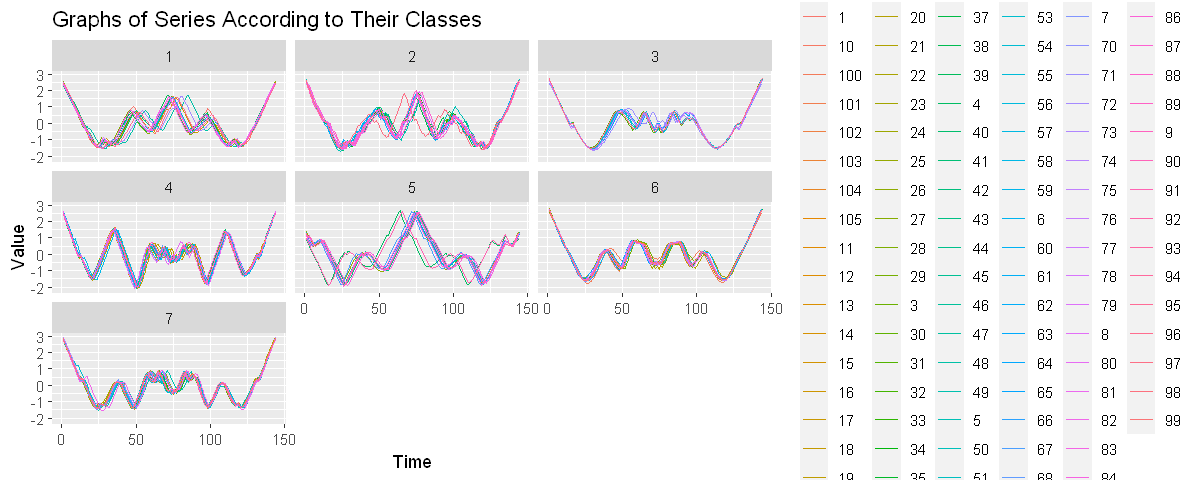

In [43]:
ggplot(series_long[["plane"]], aes(time,value)) + geom_line(aes(color=as.character(id))) +
     facet_wrap(~class) +
     labs(title= "Graphs of Series According to Their Classes", x= "Time", y="Value")

## Data Representation and Preperation

In [34]:
series <- list()
series[["ecg"]] <- fread("C:/Users/kaan9/OneDrive/Masaüstü/Homework3/Datas/TRAIN/ecg_TRAIN.txt")
series[["italy"]] <- fread("C:/Users/kaan9/OneDrive/Masaüstü/Homework3/Datas/TRAIN/italy_TRAIN.txt")
series[["subspace"]] <- fread("C:/Users/kaan9/OneDrive/Masaüstü/Homework3/Datas/TRAIN/subspace_TRAIN.txt")
series[["power"]] <- fread("C:/Users/kaan9/OneDrive/Masaüstü/Homework3/Datas/TRAIN/power_TRAIN.txt")
series[["plane"]] <- fread("C:/Users/kaan9/OneDrive/Masaüstü/Homework3/Datas/TRAIN/plane_TRAIN.txt")
for(s in series){
    setnames(s,1,"class")
    s[,id:=1:nrow(s)]
}

Data is read and stored as a "list" object. Then, series are cast to long format and 3 different representations are applied: differenced series, partitioning with tree algorithm with "maxdepth" parameters 5 and 10. Finally, every representation again stored as a list object. List is coded as "(series name)-(representation)", for exmple "ecg_tree5" means ECG data set, represented with tree algorithm with maxdepth parameter 5. For 5 different data sets, 4 different representation applied. There are 20 different data in the list object.

In [35]:
series_long <- list()
for(n in names(series)){
    series_long[[n]] <- melt(series[[n]],id.vars = c("id","class"))
    series_long[[n]][,time:=as.numeric(gsub("V", "", variable))-1]
    setorder(series_long[[n]],id)
    diff <- numeric(0)
    tree_5 <- numeric(0)
    tree_10 <- numeric(0)
    for(i in unique(series_long[[n]]$id)){
        temp_dt <- series_long[[n]][id==i,]
        temp_dt[,time:=1:.N]
        diff <- c(diff,(temp_dt$value-shift(temp_dt$value,1)))
        temp_tree_5 <- rpart(value~time,temp_dt,maxdepth=5)
        temp_tree_10 <- rpart(value~time,temp_dt,maxdepth=10)
        tree_5 <- c(tree_5,predict(temp_tree_5,temp_dt))
        tree_10 <- c(tree_10,predict(temp_tree_10,temp_dt))
    }
    series_long[[n]][,`:=`(tree5=tree_5,
                           tree10=tree_10,
                           diff = diff)]
    series_long[[n]]$diff[is.na(series_long[[n]]$diff)] <- mean(abs(series_long[[n]]$diff[!is.na(series_long[[n]]$diff)]))
    series[[paste(n,"tree5",sep="_")]] <- dcast(series_long[[n]],id~variable,value.var="tree5")
    series[[paste(n,"tree10",sep="_")]] <- dcast(series_long[[n]],id~variable,value.var="tree10")
    series[[paste(n,"diff",sep="_")]] <- dcast(series_long[[n]],id~variable,value.var="diff")
}

## Approach and Model

Before the construction of the k-NN classifier algorithm, for every time series with every representation distance matrices are calculated. 4 different distance measures are used: Dynamic Time Warping with Sakoe-Chiba constraint (DTW), Longest Common Subsequence (LCSS) and Edit Distance on Real Sequences (EDR). Parameters for distance measures taken as default. Matrices are coded as "(series)-(representation)-(distance measure)", for example "ecg_tree5_dtw" means DTW distance matrix of ECG data set with tree representation with maxdepth 5. For every raw and represented series, 4 different distance matrices are calculated, so there are 80 different distance matrices.

In [14]:
distances <- list()
for(n in names(series)){
 
    distances[[paste(n,"euc",sep="_")]] <- as.matrix(dist(series[[n]]))
    diag(distances[[paste(n,"euc",sep="_")]]) <- 10000
    
    distances[[paste(n,"dtw",sep="_")]] <- as.matrix(dtwDist(series[[n]],window.type='sakoechiba',window.size=10))
    diag(distances[[paste(n,"dtw",sep="_")]]) <- 10000
   
    distances[[paste(n,"lcss",sep="_")]] <- as.matrix(TSDatabaseDistances(series[[n]],distance='lcss',epsilon=0.05))
    diag(distances[[paste(n,"lcss",sep="_")]]) <- 10000
    
    distances[[paste(n,"edr",sep="_")]] <- as.matrix(TSDatabaseDistances(series[[n]],distance='erp',g=0.5))
    diag(distances[[paste(n,"edr",sep="_")]]) <- 10000
    
}
save(distances,file="C:/Users/kaan9/OneDrive/Masaüstü/Homework3/Datas/TRAIN/distances.RData")

In [1]:
load("C:/Users/kaan9/OneDrive/Masaüstü/Homework3/Datas/TRAIN/distances.RData")

To find the best parameters, cross validation with 5 repetetions and 10 folds is applied. Test indices are seperated which is shown below.

In [7]:
set.seed(131)
cv_indices <- list(0)
trainclasses <- list()
for(n in names(series)){
    trainclasses[[n]] <- series[[n]]$class
    cv_indices[[n]] <- generateCVRuns(trainclasses[[n]], ntimes =5, nfold = 10, 
                                      leaveOneOut = FALSE, stratified = TRUE)
}

ERROR: Error in indices[[k]]: altindis sınırlar dışında


In [ ]:
nn_classify_cv=function(dist_matrix,train_class,test_indices,k=1){
    
    test_distances_to_train=dist_matrix[test_indices,]
    test_distances_to_train=test_distances_to_train[,-test_indices]
    train_class=train_class[-test_indices]
    #print(str(test_distances_to_train))
    ordered_indices=apply(test_distances_to_train,1,order)
    if(k==1){
        nearest_class=as.numeric(train_class[as.numeric(ordered_indices[1,])])
        nearest_class=data.table(id=test_indices,nearest_class)
    } else {
        nearest_class=apply(ordered_indices[1:k,],2,function(x) {train_class[x]})
        nearest_class=data.table(id=test_indices,t(nearest_class))
    }
    
    long_nn_class=melt(nearest_class,'id')
    class_counts=long_nn_class[,.N,list(id,value)]
    class_counts[,predicted_prob:=N/k]
    wide_class_prob_predictions=dcast(class_counts,id~value,value.var='predicted_prob')
    wide_class_prob_predictions[is.na(wide_class_prob_predictions)]=0
    class_predictions=class_counts[,list(predicted=value[which.max(N)]),by=list(id)]
    return(list(prediction=class_predictions,prob_estimates=wide_class_prob_predictions))
    
}

For the k-NN model, "nn_classify_cv" function is used for model calculations. 3 different k levels are applied: 1, 3 and 5. For every repetetion and fold of the different parameters, mean accuracy and standard deviation of the accuracy is calculated. For every data sets, 4 different representations, 4 different distance measures and 3 different k values are applied for the k-NN algorithm, so there is 48 different models for every data sets. Results are stored as a data frame to find the model with highest accuracy.

In [30]:
k_levels <- c(1,3,5)
results <- data.table(serie=character(0),model=character(0),mean_acc=numeric(0),sd_acc=numeric(0))
for(matr in names(distances)){
    seri <- substr(matr,start = 1,stop=gregexpr(pattern ='_',matr)[[1]][1]-1)
    for(k in k_levels){
        acc_temp <- numeric(0)
        for(rep in 1:5){
            this_rep <- cv_indices[[seri]][[rep]]
            for(fold in 1:10){
                test_indices <- this_rep[[fold]]
                preds <- nn_classify_cv(distances[[matr]],trainclasses[[seri]],
                                        test_indices,k)$prediction$predicted
                acc_temp <- c(acc_temp,
                              accuracy(trainclasses[[seri]][test_indices],preds))
            }
        }
        results <- rbind(results,list(seri,paste(matr,as.character(k),sep="_"),mean(acc_temp),sd(acc_temp)))
    }
}

## Conclusion

In [48]:
temp <- results[,max(mean_acc),by=list(serie)]
results[temp,on=.(serie=serie,mean_acc=V1)]

serie,model,mean_acc,sd_acc
ecg,ecg_edr_3,0.8000000,0.10690450
italy,italy_edr_1,0.7971429,0.15190341
subspace,subspace_edr_1,1.0000000,0.00000000
subspace,subspace_edr_3,1.0000000,0.00000000
subspace,subspace_edr_5,1.0000000,0.00000000
subspace,subspace_diff_dtw_1,1.0000000,0.00000000
subspace,subspace_diff_dtw_5,1.0000000,0.00000000
power,power_euc_5,0.9966667,0.01332766
plane,plane_edr_1,0.9790909,0.04465909


For every data set, the best model parameters and best mean accuracy with its standard deviation is extracted and shown above as a table. For the "Power Cons" and "Planes" data sets, model predicts with very high accuracy and small standard deviation. "Smooth Subspaces" data set is predicted with perfect accuracy value 1 and 0 standard deviation because it is a data set easy to predict to work with clustering algorithms. For "ECG" and "Italy's Power Demand" data sets, model predicts with 80% accuracy but with high standard deviations. It is not better than other data sets but still the model is accurate enough for future predictions.